In [1]:
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import os
from tqdm.auto import tqdm, trange
from collections import OrderedDict
from PIL import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from utils.dataset import SegmentationDataset, TransformDataset, transforms as T
from utils.vis import show_torch_batch, show_torch_img
from utils.metrics import ConfusionMatrix
from models import deeplabv3, half_precision

In [2]:
disable_cuda = False
num_classes = 2
num_epochs = 30
batch_size = 4
ignore_index = 100  # Value of labels that we ignore in loss and other logic (e.g. kelp with unknown species)
prep_datasets = True
dataset_path = Path('../checkpoints/datasets.pt')
 
if not disable_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using device:", device)

Using device: cuda


In [3]:
# Make results reproducable
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

# Datasets

In [4]:
dataloader_opts = {
    "batch_size": batch_size, 
    "pin_memory": True, 
    "drop_last": True,
    "num_workers": os.cpu_count()
}

if prep_datasets:
    ds_paths = [
        "../data/datasets/kelp/nw_calvert_2012",
        "../data/datasets/kelp/nw_calvert_2015", 
        "../data/datasets/kelp/choked_pass_2016",
        "../data/datasets/kelp/west_beach_2016"
    ]
    ds = torch.utils.data.ConcatDataset([SegmentationDataset(path) for path in ds_paths])

    train_num = int(len(ds) * 0.8)
    val_num = len(ds) - train_num
    ds_train, ds_val = torch.utils.data.random_split(ds, [train_num, val_num])

    # Bind data transforms to the subset datasets
    ds_train = TransformDataset(ds_train, T.train_transforms, T.train_target_transforms)
    ds_val = TransformDataset(ds_val, T.test_transforms, T.test_target_transforms)

    dataloaders = {
        'train': DataLoader(ds_train, shuffle=True, **dataloader_opts),
        'eval': DataLoader(ds_val, shuffle=False, **dataloader_opts),
    }

    print("Training samples:", train_num)
    print("Validation samples:", val_num)

Training samples: 48540
Validation samples: 12136


In [5]:
def ds_pixel_stats(dataloader):
    pixel_counts = torch.zeros((num_classes)).to(device)

    for x, y in tqdm(iter(dataloader)):
        try:
            un, counts = torch.unique(y.to(device), return_counts=True)
            mask = un != ignore_index
            pixel_counts.index_add_(0, un[mask], counts[mask].float())
        except Exception:
            import pdb; pdb.set_trace()
    
    pixel_ratio = pixel_counts / pixel_counts.sum(dim=0)
    pixel_counts = pixel_counts.detach().cpu().numpy()
    pixel_ratio = np.around(pixel_ratio.detach().cpu().numpy(), 4)
    
    return pixel_ratio, pixel_counts 

In [6]:
# for i in range(len(ds_train)):
#     if ds_train[i][0].shape != torch.Size([3,200,200]):
#         print(ds_train[i][0].shape)


[0.9657 0.0343]


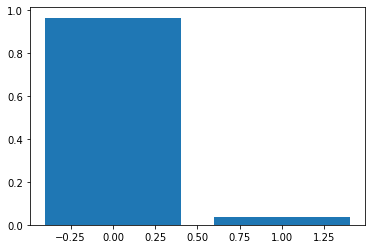


[0.9596 0.0404]


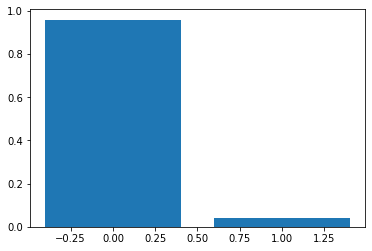

In [7]:
if prep_datasets:
    train_proportions, train_counts = ds_pixel_stats(dataloaders['train'])
    print(train_proportions)
    plt.figure(); plt.bar(range(num_classes), train_proportions); plt.show()

    val_proportions, val_counts = ds_pixel_stats(dataloaders['eval'])
    print(val_proportions) 
    plt.figure(); plt.bar(range(num_classes), val_proportions); plt.show()

# Undersample kelp-free empty images

In [ ]:
def get_indices_of_kelp_images(dataset):
    dl = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=os.cpu_count())
    indices = []
    
    for i, (_, y) in enumerate(tqdm(iter(dl))):
        if torch.any(y > 0):
            indices.append(i)
    return indices

if prep_datasets:
    train_indices = get_indices_of_kelp_images(ds_train)
    val_indices = get_indices_of_kelp_images(ds_val)

    ds_train = torch.utils.data.Subset(ds_train, train_indices)
    ds_val = torch.utils.data.Subset(ds_val, val_indices)
    ds_overfit = torch.utils.data.Subset(ds_train, range(0, batch_size))

    torch.save({
        'train': ds_train,
        'val': ds_val,
        'overfit': ds_overfit
    }, dataset_path)
else:
    dataset_saved = torch.load(dataset_path)
    ds_train = dataset_saved['train']
    ds_val = dataset_saved['val']
    ds_overfit = dataset_saved['overfit']
    

dataloaders = {
    'train': DataLoader(ds_train, shuffle=True, **dataloader_opts),
    'eval': DataLoader(ds_val, shuffle=False, **dataloader_opts),
    'overfit': DataLoader(ds_overfit, shuffle=False, **dataloader_opts)
}

In [ ]:
train_proportions, train_counts = ds_pixel_stats(dataloaders['train'])
print(train_proportions)
plt.figure(); plt.bar(range(num_classes), train_proportions); plt.show()

val_proportions, val_counts = ds_pixel_stats(dataloaders['eval'])
print(val_proportions) 
plt.figure(); plt.bar(range(num_classes), val_proportions); plt.show()

# Net, opt, loss

In [ ]:
model = deeplabv3.create_model(num_classes)
model = model.to(device)
# model = half_precision(model)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
# from utils.loss import CBLoss
# criterion = CBLoss(train_counts.astype(np.int32), num_classes, "focal", 0.9999, 2.0)

# Overfit to a single batch to ensure things work

In [ ]:
def overfit_model_to_single_batch(model, dataloader, optimizer, criterion, num_epochs):
    model.train()
    
    info = OrderedDict()
    sum_iou = np.zeros(num_classes)
    cm = ConfusionMatrix(num_classes).to(device)
    
    with trange(1, num_epochs+1) as pbar:
        for epoch in pbar:
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()

                pred = model(x)['out']
                loss = criterion(pred, y)

                loss.backward()
                optimizer.step()

                if epoch % 100 == 0:
                    show_torch_batch(x, y, pred)

                # Compute metrics
                loss = loss.detach().cpu().item()
                info['batch_loss'] = loss

                cm.update(y, pred.max(dim=1)[1])
                info['IoUs'] = np.around(np.nan_to_num(cm.get_iou().detach().cpu().numpy()), 4)

                pbar.set_postfix(info)
    
    return model
    
# model = overfit_model_to_single_batch(model, dataloaders['overfit'], optimizer, criterion, 10)

# Train the model

In [ ]:
def train_model(model, dataloaders, num_classes, optimizer, criterion, num_epochs, save_path, start_epoch=0):
    writer = SummaryWriter()
    info = OrderedDict()
    
    best_loss = None
    
    for epoch in trange(start_epoch, num_epochs, desc="epoch"):
        sum_loss = 0.
        sum_iou = np.zeros(num_classes)
        cm = ConfusionMatrix(num_classes).to(device)
        
        for phase in ['train', 'eval']:
            with tqdm(iter(dataloaders[phase]), desc=phase) as pbar:
                for i, (x, y) in enumerate(pbar):
                    global_step = (epoch+1)*(i+1)
                    
                    x = x.to(device)
                    y = y.to(device)

                    optimizer.zero_grad()

                    if phase == 'train':
                        model.train()
                    else:
                        model.eval()

                    pred = model(x)['out']
                    loss = criterion(pred, y)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Compute metrics
                    sum_loss += loss.detach().cpu().item()
                    info['mean_loss'] = sum_loss / (i+1)

                    mask = y != ignore_index
                    cm.update(y[mask], pred.max(dim=1)[1][mask])
                    info['IoUs'] = np.around(np.nan_to_num(cm.get_iou().detach().cpu().numpy()), 4)

                    pbar.set_postfix(info)
                    
#                     if global_step == 1:
#                         writer.add_graph(model, x)
                    
                    writer.add_scalar(f'Loss/{phase}', info['mean_loss'], global_step)
                    writer.add_scalar(f'Mean IoU/{phase}', np.mean(info['IoUs']), global_step)
                    writer.add_histogram(f'IoUs/{phase}', info['IoUs'], global_step, bins=num_classes)
#                     import pdb; pdb.set_trace()
                    if global_step % 500 == 0:
                        # Show images
                        img_grid = torchvision.utils.make_grid(x, nrow=x.shape[0])
                        img_grid = T.inv_normalize(img_grid)

                        # Show labels and predictions
                        y = y.unsqueeze(dim=1)
                        label_grid = torchvision.utils.make_grid(y, nrow=y.shape[0]).type(torch.FloatTensor).cuda()
                        label_grid = alpha_blend(img_grid, label_grid)
                        writer.add_image(f'{phase}/labels', label_grid, global_step)

                        # Show predictions
                        pred = pred.max(dim=1)[1].unsqueeze(dim=1)
                        pred_grid = torchvision.utils.make_grid(pred, nrow=pred.shape[0]).type(torch.FloatTensor).cuda()
                        pred_grid = alpha_blend(img_grid, pred_grid)
                        writer.add_image(f'{phase}/preds', pred_grid, global_step)
                        
            # Show a batch of images
            # show_torch_batch(x, y, pred)

                
        # Model checkpointing after eval stage
        if best_loss is None or info['mean_loss'] < best_loss:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'mean_eval_loss': info['mean_loss'],
                }, save_path)
        
    writer.close()
 
    return model


def alpha_blend(bg, fg, alpha=0.5):   
    return fg*alpha + bg*(1-alpha)
    

In [ ]:
from pathlib import Path
save_path = Path('../checkpoints/deeplabv3/checkpoint.pt')
save_path.parents[0].mkdir(parents=True, exist_ok=True)

if Path(save_path).exists():
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
else:
    epoch = 0

model =  train_model(model, dataloaders, num_classes, optimizer, criterion, num_epochs, save_path, start_epoch=epoch)

## TODO

- Change mixed class to don't care
- Try different optimizer
- ~~Train for Kelp/Not Kelp only~~
- Check that changing prior doesn't affect performance too badly
- Optimize regularization

## TO TRY
- Add Jaccard index loss as in https://www.kaggle.com/windsurfer/baseline-u-net-on-pytorch
- Straight Jaccard loss
- ~~Undersample Kelp-free images~~
- Oversample images with kelp
- Try UNet